## Imports

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import gensim
import nltk
import spacy
import re
import spacy
import matplotlib.pyplot as plt
import string
import math

from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk import tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from spacy import displacy
from transformers import pipeline
from itertools import product

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Read data

In [ ]:
prompts_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
prompts_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
sample_submission = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")
summaries_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")
summaries_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")

## Explore data

In [ ]:
prompts_train.head()

In [ ]:
prompts_train.dtypes

In [ ]:
prompts_test.head()

In [ ]:
prompts_test.dtypes

In [ ]:
sample_submission.head()

In [ ]:
sample_submission.dtypes

In [ ]:
summaries_test.head()

In [ ]:
summaries_test.dtypes

In [ ]:
summaries_train.head()

In [ ]:
summaries_train.dtypes

In [ ]:
# Joining summaries_train and prompts_train on "prompt_id"
merged_train = pd.merge(summaries_train, prompts_train, on="prompt_id", how="inner")
merged_train.head()

In [ ]:
profile = ProfileReport(merged_train, title="Profiling Report")
profile

As we can see vording and content are highly correlated, but this is predictable, because usually, if people write work well, both values will be high
## Label distribution

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(121)
sns.histplot(data=merged_train, x='content')
plt.subplot(122)
sns.histplot(data=merged_train, x='wording')
plt.show()

## Preprocess data

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(text):
    # Check if input is a string
    if not isinstance(text, str):
        return text

    # Initialize stopwords, lemmatizer, and punctuation set
    stop_words = set(stopwords.words('english'))

    # Remove links
    # text = re.sub(r"http\S+", "", text)
    text = re.sub(r'[\r\n]+', ". ", text)
    # text = text.replace("\r\n", ". ")
    # Remove period occurence with those symbols
    for symb in ["!", ",", ":", ";", "?"]:
        text = re.sub(rf"\{symb}\.", symb, text)
    #input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
    text = re.sub("[^a-zA-Z0-9!\’\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", text)
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    text = collapse_dots(text)
    text = text.lower()
    
    # # Lemmatize
    # nlp = spacy.load("en_core_web_sm")
    # doc = nlp(text)
    # text = " ".join([token.lemma_ for token in doc])

    # Remove leading and ending whitespace
    text = text.strip()
    return text

In [ ]:
merged_train["clean_text"] = merged_train["text"].apply(process_text)
merged_train["clean_prompt_text"] = merged_train["prompt_text"].apply(process_text)
for idx in [10, 100 , 150]:
    print(
        f"Before : {merged_train['text'][idx]}\n"
        f"Light Processing : {merged_train['clean_text'][idx]}\n"
    )

In [ ]:
# SOURCE: https://www.kaggle.com/code/gusthema/commonlit-evaluate-student-summaries-w-tfdf/notebook

# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text.
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

# This function applies all the above preprocessing functions on a text feature.
def feature_engineer(dataframe_real: pd.DataFrame, feature: str = 'clean_text') -> pd.DataFrame:
    dataframe = dataframe_real.copy()
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [ ]:
merged_train_stats = feature_engineer(merged_train)
merged_train_stats.head()
# text_length is measured in symbols

In [ ]:
merged_train_stats.describe()

In [ ]:
merged_train_stats["merged_text"] = (
    merged_train_stats["prompt_title"] + ". " + merged_train_stats["prompt_question"] + " " +  merged_train_stats["clean_prompt_text"] + ". " + merged_train_stats["clean_text"]
)

merged_train_stats["merged_text"].iloc[10]

## Split data into train and validation datasets

In [ ]:
x_train_content, x_validate_content, y_train_content, y_validate_content = train_test_split(
    merged_train_stats["merged_text"],
    merged_train_stats["content"],
    test_size=0.3,random_state=1
)
x_train_wording, x_validate_wording, y_train_wording, y_validate_wording = train_test_split(
    merged_train_stats["merged_text"],
    merged_train_stats["wording"],
    test_size=0.3,random_state=1
)

## Create Pipeline
Let's start with simple LinearRegression

In [ ]:
pipe_regression_content = Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        strip_accents='ascii',
        stop_words='english',
        ngram_range=(1, 3),
        min_df=5,
        max_features=30000
    )),  
    ('regressor', LinearRegression())
])
pipe_regression_wording = Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        strip_accents='ascii',
        stop_words='english',
        ngram_range=(1, 3),
        min_df=5,
        max_features=30000
    )),  
    ('regressor', LinearRegression())
])
pipe_regression_content.fit(x_train_content, y_train_content)
pipe_regression_wording.fit(x_train_wording, y_train_wording)

In [ ]:
predictions_train_content = pipe_regression_content.predict(x_train_content)
predictions_train_wording = pipe_regression_wording.predict(x_train_wording)
predictions_validate_content = pipe_regression_content.predict(x_validate_content)
predictions_validate_wording = pipe_regression_wording.predict(x_validate_wording)

## Evaluate

In [ ]:
def RMSE(actual: np.ndarray, predicted: np.ndarray) -> float:
    return math.sqrt(((actual-predicted)**2).mean())
 
print(f'RMSE Train content: {RMSE(y_train_content, predictions_train_content)}',
      f'RMSE Validate content: {RMSE(y_validate_content, predictions_validate_content)}')
print(f'RMSE Train wording: {RMSE(y_train_wording, predictions_train_wording)}',
      f'RMSE Validate wording: {RMSE(y_validate_wording, predictions_validate_wording)}')

As we see, the model is overfitting. Let's try linear regression with reguralization, for example,  sklearn.linear_model.ElasticNet

In [ ]:
pipe_regression_content_EN = Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        strip_accents='ascii',
        stop_words='english',
        ngram_range=(1, 3),
        min_df=5,
        max_features=30000
    )),  
    ('regressor', ElasticNet(alpha=0.5))
])
pipe_regression_wording_EN = Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        strip_accents='ascii',
        stop_words='english',
        ngram_range=(1, 3),
        min_df=5,
        max_features=30000
    )),  
    ('regressor', ElasticNet(alpha=0.5))
])
pipe_regression_content_EN.fit(x_train_content, y_train_content)
pipe_regression_wording_EN.fit(x_train_wording, y_train_wording)

In [ ]:
predictions_train_content_EN = pipe_regression_content_EN.predict(x_train_content)
predictions_train_wording_EN = pipe_regression_wording_EN.predict(x_train_wording)
predictions_validate_content_EN = pipe_regression_content_EN.predict(x_validate_content)
predictions_validate_wording_EN = pipe_regression_wording_EN.predict(x_validate_wording)
print(f'RMSE Train content: {RMSE(y_train_content, predictions_train_content_EN)}',
      f'RMSE Validate content: {RMSE(y_validate_content, predictions_validate_content_EN)}')
print(f'RMSE Train wording: {RMSE(y_train_wording, predictions_train_wording_EN)}',
      f'RMSE Validate wording: {RMSE(y_validate_wording, predictions_validate_wording_EN)}')

We get better results for content prediction (and a little bit better for wording prediction). Let's also try Gradient boosting regression tree model:

In [ ]:
pipe_regression_content_GBR = Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        strip_accents='ascii',
        stop_words='english',
        ngram_range=(1, 3),
        min_df=5,
        max_features=30000
    )),  
    ('regressor', GradientBoostingRegressor(random_state=1))
])
pipe_regression_wording_GBR = Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        strip_accents='ascii',
        stop_words='english',
        ngram_range=(1, 3),
        min_df=5,
        max_features=30000
    )),  
    ('regressor', GradientBoostingRegressor(random_state=1))
])
pipe_regression_content_GBR.fit(x_train_content, y_train_content)
pipe_regression_wording_GBR.fit(x_train_wording, y_train_wording)

In [ ]:
predictions_train_content_GBR = pipe_regression_content_GBR.predict(x_train_content)
predictions_train_wording_GBR = pipe_regression_wording_GBR.predict(x_train_wording)
predictions_validate_content_GBR = pipe_regression_content_GBR.predict(x_validate_content)
predictions_validate_wording_GBR = pipe_regression_wording_GBR.predict(x_validate_wording)
print(f'RMSE Train content: {RMSE(y_train_content, predictions_train_content_GBR)}',
      f'RMSE Validate content: {RMSE(y_validate_content, predictions_validate_content_GBR)}')
print(f'RMSE Train wording: {RMSE(y_train_wording, predictions_train_wording_GBR)}',
      f'RMSE Validate wording: {RMSE(y_validate_wording, predictions_validate_wording_GBR)}')

As we see we get even better results with GradientBoostingRegressor, but the disadvantage is longer computing time. Let's also try different approach: we will use GradientBoostingRegressor and data obtained from feature_engineer

In [ ]:
# Features that will be used to predict wording and content: number of words, symbols, stopwords in the text, etc.
features = merged_train_stats.drop(columns = ['student_id', 'prompt_id', 'text', 'content',
'wording', 'prompt_question', 'prompt_title', 'prompt_text','clean_text','clean_prompt_text', 'merged_text'], axis = 1).columns.to_list()
label_encoder = LabelEncoder()

# Fit and transform the 'prompt_question' column
# It is used to track summaries written on different questions
merged_train_stats['prompt_question_encoded'] = label_encoder.fit_transform(merged_train_stats['prompt_question'])
merged_train_stats.head()

In [ ]:
features

In [ ]:
train_features = features.copy()
train_features.append("prompt_question_encoded")
x_tr_stats_content, x_vld_stats_content, y_tr_stats_content, y_vld_stats_content = train_test_split(
    merged_train_stats[train_features],
    merged_train_stats["content"],
    test_size=0.3,random_state=1
)
x_tr_stats_wording, x_vld_stats_wording, y_tr_stats_wording, y_vld_stats_wording = train_test_split(
    merged_train_stats[train_features],
    merged_train_stats["wording"],
    test_size=0.3,random_state=1
)

In [ ]:
pipe_regression_stats_content_GBR = GradientBoostingRegressor(random_state=1)
pipe_regression_stats_wording_GBR = GradientBoostingRegressor(random_state=1)
pipe_regression_stats_content_GBR.fit(x_tr_stats_content, y_tr_stats_content)
pipe_regression_stats_wording_GBR.fit(x_tr_stats_wording, y_tr_stats_wording)

In [ ]:
predictions_tr_stats_content_GBR = pipe_regression_stats_content_GBR.predict(x_tr_stats_content)
predictions_tr_stats_wording_GBR = pipe_regression_stats_wording_GBR.predict(x_tr_stats_wording)
predictions_vld_stats_content_GBR = pipe_regression_stats_content_GBR.predict(x_vld_stats_content)
predictions_vld_stats_wording_GBR = pipe_regression_stats_wording_GBR.predict(x_vld_stats_wording)
print(f'RMSE Train content: {RMSE(y_tr_stats_content, predictions_tr_stats_content_GBR)}',
      f'RMSE Validate content: {RMSE(y_vld_stats_content, predictions_vld_stats_content_GBR)}')
print(f'RMSE Train wording: {RMSE(y_tr_stats_wording, predictions_tr_stats_wording_GBR)}',
      f'RMSE Validate wording: {RMSE(y_vld_stats_wording, predictions_vld_stats_wording_GBR)}')

This simpler in some sense model provides even better results than the previuos one, which took into account all text. We will use this one for a submission part.

## Submission part for scoring on kaggle

In [ ]:
merged_test = pd.merge(summaries_test, prompts_test, on="prompt_id", how="inner")
merged_test["clean_text"] = merged_test["text"].apply(process_text)
merged_test_stats = feature_engineer(merged_test)
merged_test_stats['prompt_question_encoded'] = label_encoder.fit_transform(merged_test_stats['prompt_question'])
merged_test_stats['content'] = pipe_regression_stats_content_GBR.predict(merged_test_stats[train_features])
merged_test_stats['wording'] = pipe_regression_stats_wording_GBR.predict(merged_test_stats[train_features])
merged_test_stats.head()

In [ ]:
merged_test_stats[['student_id', 'content', 'wording']].to_csv('submission.csv',index=False)
display(pd.read_csv('submission.csv'))

To improve the model, we can try to combine prediction based on the whole text as well its syntactic characteristics. We can also try to apply lemmatization and more substantial processing to the text to discard non-essential words.

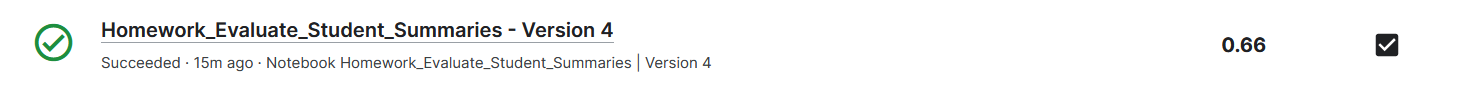
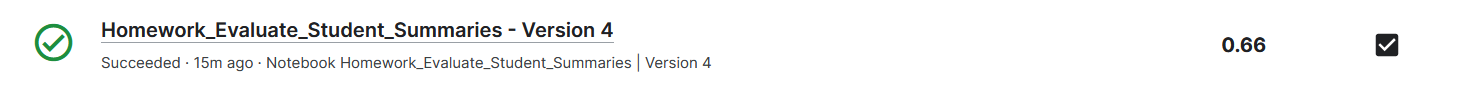